# Ultrasound processing Code

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from pymatreader import read_mat
from tqdm import tqdm
from scipy.signal import hilbert


class UltrasoundImage:
    def __init__(self, element=128, col_pixel=128, row_pixel=2048, col_spacing=0.3e-3, height=0.04, target_size=(400,400)) -> None:
        self.__element = element
        self.__col_pixel = col_pixel
        self.__row_pixel = row_pixel
        self.__col_spacing = col_spacing
        self.__height = height
        self.__row_spacing = height / row_pixel
        self.__target_size = target_size

    def convert_mat_to_np(self, mat_path, key=None):
        if key == 'img':
            self.__original_img_arr = np.array(read_mat(mat_path)[key])
        elif key == 'rfdata':
            self.__rfdata_arr = np.array(read_mat(mat_path)[key])
        else:
            self.__mat_arr = np.array(read_mat(mat_path))

    def scan_conversion(self, key):
        try:
            if key == 'img':
                img_arr = self.__original_img_arr
                self.__original_img = np.array([scipy.ndimage.zoom(img_arr[:,:,i], (self.__target_size[0] / img_arr.shape[0], self.__target_size[1] / img_arr.shape[1])) for i in range(img_arr.shape[2])])
            elif key == 'rfdata':
                scan_conversion_pixels = list()
                for i in range(self.__log_pixels.shape[0]):
                    img = self.__log_pixels[i]
                    scan_conversion_pixels.append(scipy.ndimage.zoom(img, (self.__target_size[0] / img.shape[0], self.__target_size[1] / img.shape[1])))
                self.__scan_conversion_pixels = np.array(scan_conversion_pixels)
        except:
            print("Please load an image first")

    def show_img(self, key, idx):
        try:
            if key == 'img':
                img = self.__original_img
            elif key == 'rfdata':
                img = self.__rfdata_img
            plt.imshow(img[idx], cmap='gray')
            plt.xticks(np.arange(0, 401, 100), labels=['0', '1', '2', '3', '[cm]'])
            plt.yticks(np.arange(0, 401, 100), labels=['[cm]', '1', '2', '3', '4'])
            plt.colorbar(label='[dB]')
            plt.show()
        except:
            print("Please load an image first")
    
    def cal_distance(self):
        distance = np.zeros((self.__element, self.__row_pixel, self.__col_pixel))
        
        print("Calculating distance")
        for ele in tqdm(range(self.__element)):
            for row in range(self.__row_pixel):
                if row == 0:
                    distance[ele][row][ele] = self.__row_spacing / 2
                else:
                    distance[ele][row][ele] = distance[ele][row-1][ele] + self.__row_spacing
        for ele in tqdm(range(self.__element)):
            for row in range(self.__row_pixel):
                for col in range(ele+1, self.__col_pixel):
                    distance[ele][row][col] = np.sqrt((np.abs(ele-col) * self.__col_spacing)**2 + distance[ele][row][ele]**2)
                for col in range(ele-1, -1, -1):
                    distance[ele][row][col] = np.sqrt((np.abs(ele-col) * self.__col_spacing)**2 + distance[ele][row][ele]**2)
        self.__distance = distance

    def delay_and_sum(self, sound_speed=1540, center_freq=7.6e6, sampling_rate=4.1):
        def cal_weight(p):
            i = int(p)
            f = p - i
            return (1-f, f)
        
        sampling_freq = center_freq * sampling_rate
        delay = np.zeros((self.__element, self.__row_pixel, self.__col_pixel))
        
        print("Calculating delay")
        for ele in tqdm(range(self.__element)):
            for row in range(self.__row_pixel):
                d = (self.__row_spacing / 2) + (row * self.__row_spacing)
                for col in range(self.__col_pixel):
                    l = self.__distance[ele][row][col]
                    delay[ele][row][col] = ((d + l) / sound_speed) * sampling_freq

        pixels = list()
        print("Calculating sum")
        # for i in tqdm(range(self.__rfdata_arr.shape[2])):
        for i in tqdm(range(1)):
            pixel = np.zeros((self.__row_pixel, self.__col_pixel))
            for row in tqdm(range(self.__row_pixel)):
                for col in range(self.__col_pixel):
                    for ele in range(self.__element):
                        p = delay[ele][row][col]
                        a, b = self.__rfdata_arr[:,:,i][int(p)][ele], self.__rfdata_arr[:,:,i][int(p)+1][ele]
                        a_w, b_w = cal_weight(p)
                        pixel[row][col] += (a * a_w + b * b_w)
            pixels.append(pixel)
        self.__pixels = np.array(pixels)
        
    def hilbert_transform(self):
        hilbert_pixels = list()

        print("Hilbert Transform")
        for i in tqdm(range(len(self.__pixels))):
            hilbert_pixels.append(np.abs(hilbert(self.__pixels[i], axis=0)))
        self.__hilbert_pixels = np.array(hilbert_pixels)

    def log_compression(self):
        try:
            self.__log_pixels = 20 * np.log10(self.__hilbert_pixels)
        except:
            print("Please perform hilbert transform first")
    
    def dynamic_range_adjustment(self, range_db=50):
        try:
            max_zero_pixels = self.__scan_conversion_pixels - np.max(self.__scan_conversion_pixels)
            self.__rfdata_img = np.maximum(max_zero_pixels, -range_db)
        except:
            print("Please perform scan conversion")

    def show_original_img(self, img_path):
        self.convert_mat_to_np(img_path, key='img')
        self.scan_conversion(key='img')
        self.show_img('img', 0)

    def processing_rfdata(self, rfdata_path, sound_speed=1540, range_db=50):
        print("read rfdata")
        self.convert_mat_to_np(rfdata_path, key='rfdata')
        print("start calculating distance")
        self.cal_distance()
        print("start delay and sum")
        self.delay_and_sum(sound_speed=sound_speed)
        print("start hilbert transform")
        self.hilbert_transform()
        print("start log compression")
        self.log_compression()
        print("start scan conversion")
        self.scan_conversion(key='rfdata')
        print("start dynamic range adjustment")
        self.dynamic_range_adjustment(range_db)
        print("Finish processing")
        print("You can use get_rfdata_img() to get the processed image")
        print("You can use show_img('rfdata', idx) to show the processed image")


    ### Setter and Getter
    def set_target_size(self, target_size):
        self.__target_size = target_size
    
    def set_row_pixel(self, row_pixel):
        self.__row_pixel = row_pixel
        self.__row_spacing = self.__height / row_pixel

    def get_raw_rfdata(self):
        return self.__rfdata_arr
    def get_distance(self):
        return self.__distance
    def get_pixels(self):
        return self.__pixels
    def get_hilbert_pixels(self):
        return self.__hilbert_pixels
    def get_log_pixels(self):
        return self.__log_pixels
    def get_scan_conversion_pixels(self):
        return self.__scan_conversion_pixels
    def get_rfdata_img(self):
        return self.__rfdata_img
    


# phantom data

## Check the original image

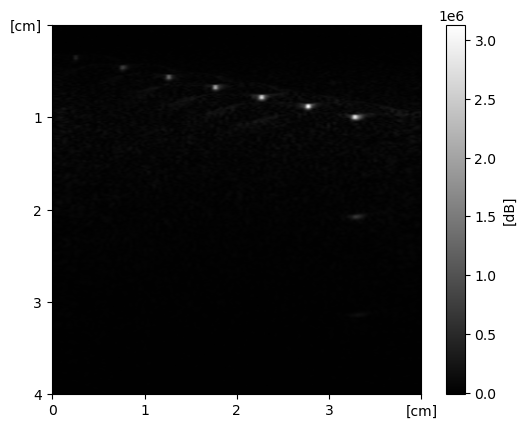

In [16]:
phantom_img_path = 'phantom/phantom_Img.mat'
phantom = UltrasoundImage()
# phantom.convert_mat_to_np(phantom_img_path, key='img')
# phantom.scan_conversion('img')
# phantom.show_img('img',0)
phantom.show_original_img(phantom_img_path)

## Processing the phantom rfdata

In [18]:
phantom_rfdata_path = 'phantom/phantom_rfdata.mat'
# phantom.convert_mat_to_np(phantom_rfdata_path, key='rfdata')
# phantom.cal_distance()
# phantom.delay_and_sum(sound_speed=1450)
# phantom.hilbert_transform()
# phantom.log_compression()
# phantom.scan_conversion('rfdata')
# phantom.dynamic_range_adjustment(50)
phantom.processing_rfdata(phantom_rfdata_path, sound_speed=1450, range_db=50)
phantom.show_img('rfdata',0)

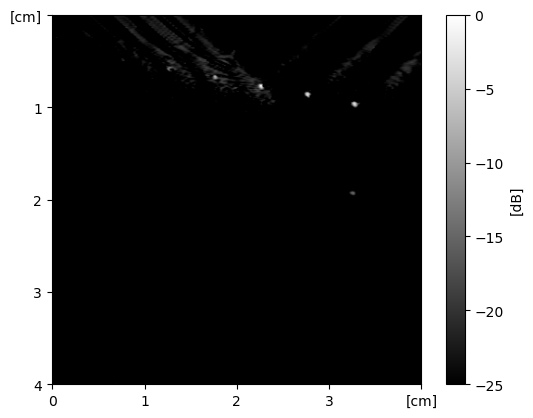

In [20]:
phantom.dynamic_range_adjustment(25)
phantom.show_img('rfdata',0)

# 202155642 Arm data

## Check the original image

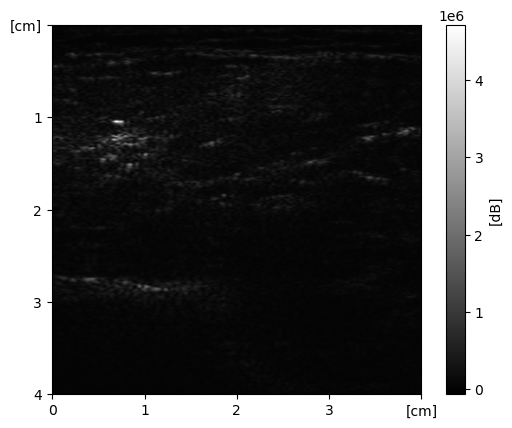

In [21]:
arm_642_img_path = '202155642/arm_Img.mat'
arm_642 = UltrasoundImage()
# arm_642.convert_mat_to_np(arm_642_img_path, key='img')
# arm_642.scan_conversion('img')
# arm_642.show_img('img',0)
arm_642.show_original_img(arm_642_img_path)

## Processing the rfdata

read rfdata
start calculating distance
Calculating distance


100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


start delay and sum
Calculating delay


100%|██████████| 128/128 [00:14<00:00,  8.86it/s]


Calculating sum


100%|██████████| 1/1 [00:45<00:00, 45.57s/it]


start hilbert transform
Hilbert Transform


100%|██████████| 1/1 [00:00<00:00, 251.38it/s]


start log compression
start scan conversion
start dynamic range adjustment
Finish processing
You can use get_rfdata_img() to get the processed image
You can use show_img('rfdata', idx) to show the processed image


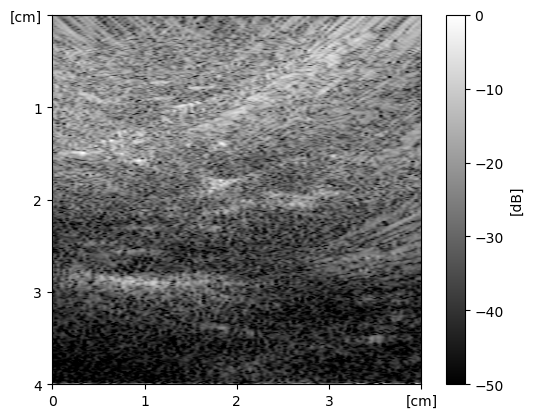

In [22]:
arm_642_rfdata_path = '202155642/arm_rfdata.mat'
# arm_642.convert_mat_to_np(arm_642_rfdata_path, key='rfdata')
# arm_642.cal_distance()
# arm_642.delay_and_sum()
# arm_642.hilbert_transform()
# arm_642.log_compression()
# arm_642.scan_conversion('rfdata')
# arm_642.dynamic_range_adjustment(50)
arm_642.processing_rfdata(arm_642_rfdata_path)
arm_642.show_img('rfdata',0)


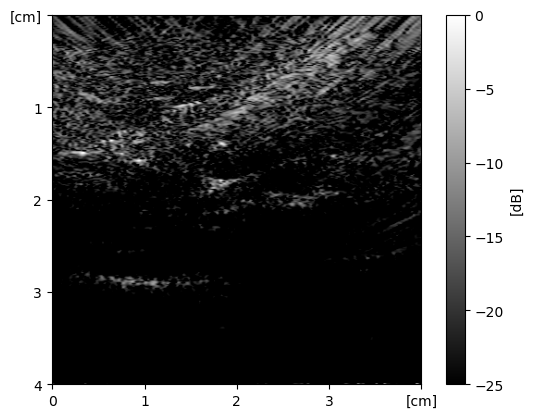

In [23]:
arm_642.dynamic_range_adjustment(25)
arm_642.show_img('rfdata',0)

# mwkim data

## Check the original image

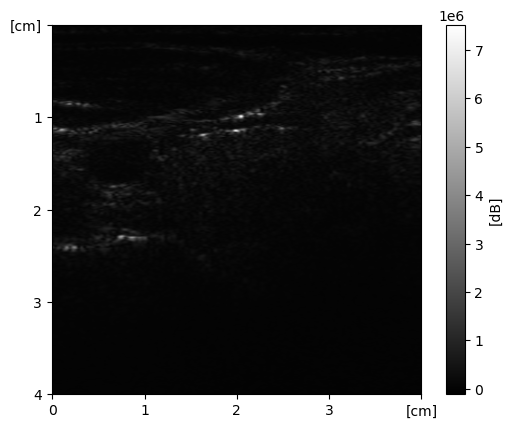

In [24]:
mwkim_img_path = 'mwkim/arm_Img.mat'
mwkim = UltrasoundImage()
# mwkim.convert_mat_to_np(mwkim_img_path, key='img')
# mwkim.scan_conversion('img')
# mwkim.show_img('img',0)
mwkim.show_original_img(mwkim_img_path)

## Processing the rfdata

In [25]:
mwkim_rfdata_path = 'mwkim/arm_rfdata.mat'
# mwkim.convert_mat_to_np(mwkim_rfdata_path, key='rfdata')
# mwkim.cal_distance()
# mwkim.delay_and_sum()
# mwkim.hilbert_transform()
# mwkim.log_compression()
# mwkim.scan_conversion('rfdata')
mwkim.processing_rfdata(mwkim_rfdata_path)

read rfdata
start calculating distance
Calculating distance


100%|██████████| 128/128 [01:02<00:00,  2.06it/s]


start delay and sum
Calculating delay


100%|██████████| 128/128 [00:14<00:00,  8.96it/s]


Calculating sum


100%|██████████| 1/1 [00:45<00:00, 45.36s/it]


start hilbert transform
Hilbert Transform


100%|██████████| 1/1 [00:00<00:00, 255.03it/s]


start log compression
start scan conversion
start dynamic range adjustment
Finish processing
You can use get_rfdata_img() to get the processed image
You can use show_img('rfdata', idx) to show the processed image


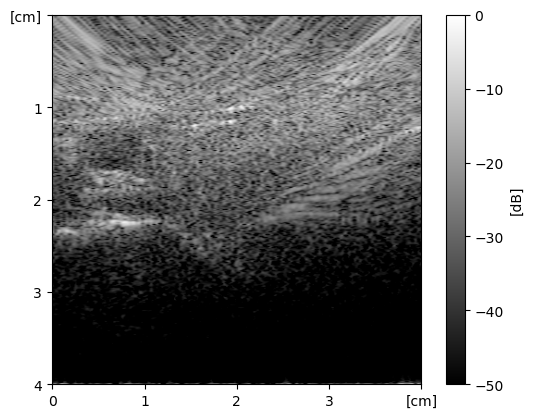

In [26]:
mwkim.show_img('rfdata',0)

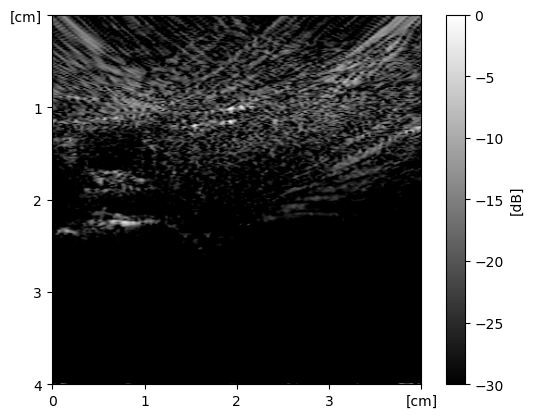

In [27]:
mwkim.dynamic_range_adjustment(30)
mwkim.show_img('rfdata',0)